In [198]:
#package imports

#astropy- various astronomical analyses package
import astropy

#Lomb Scargle periodigram method used for period analysis of system
from astropy.timeseries import LombScargle

#data handling
import numpy as np

#graphing
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
#imbedding graphs into tkinter window
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

#user interface and interaction
import tkinter

In [199]:
#defining variables

#filters used in data collection
filters = [' Infrared', ' Red', ' Visual', ' Blue']

#system name
star = 'CW Cas'

#defining AAVSO (American Association of Variable Star Observers) database period of star system (CW Cas), in days
aavso_per = 0.3188449

In [200]:
#opening dataset and extracting magnitude and timestamp data (what we graph) and separating into arrays by filter color

#loading .npy dataset; arrays of signal to noise ratio, timestamp (JD heliocentric), filter color, and magnitude
data = np.load(f'{star}_filtered.npy')

#defining dictionaries that we append data into; easiest way to deal with arrays of different sizes
mag = {}
time = {}

#separating out magnitude and time data by filter color
#changing type from string to float
for i, name in enumerate(filters):
    mag[name] = np.array(data[3][data[2] == name]).astype(float)
    time[name] = np.array(data[1][data[2] == name]).astype(float)

In [201]:
#defining functions

#graphing raw data
def raw_graph(mag, time):
    #setting graph colors based on filter color
    colors = ['darkred', 'r', 'g', 'b']
    col = 4
    row = 1
    fig, ax = plt.subplots(row, col, figsize=(6.4*col, 4.8*row))
    for i, name in enumerate(filters):
        ax[i].scatter(time[name], mag[name], c=colors[i])
        ax[i].set_ylim(np.max(mag[name])+0.05, np.min(mag[name])-0.05)
        ax[i].set_title(name)
        ax[i].set_ylabel('Magnitude')
        ax[i].set_xlabel('Time (Julian Date)')
    plt.suptitle('Raw Data')
    plt.tight_layout()

#calculating average lomb scargle periodigram period across all filters (system should have same period across all filters)
def period_analysis(mag, time):
    #setting bounds to period analysis
    min_freq = aavso_per - 0.1
    max_freq = aavso_per + 0.1

    best_period = []
    for i, name in enumerate(filters):
        frequency, power = LombScargle(time[name], mag[name]).autopower(minimum_frequency = min_freq, maximum_frequency = max_freq, samples_per_peak = 500)
        best_period.append(1/(frequency[np.argmax(power)]))

    avg_period = sum(best_period)/len(best_period)
    return avg_period

#phasing data and shifting data points such that the graph starts with the minimum value (as is astronomical convention for binary stars)
def time_calc(time, period):
    per_time = {}
    fixed_time = {}
    for i, name in enumerate(filters):
        per_time[name] = ((time[name] - time[name][0]) % period) / period
        minimum = np.argmax(mag[name])
        fixed_time[name] = per_time[name] - per_time[name][minimum]
        fixed_time[name][fixed_time[name] < 0] += 1
    return fixed_time

#graphing phased data
def phased_graph(mag, fixed_time):
    #setting graph colors based on filter color
    colors = ['darkred', 'r', 'g', 'b']
    col = 4
    row = 1
    fig, ax = plt.subplots(row, col, figsize = (6.4*col, 4.8*row))
    for i, name in enumerate(filters):
        ax[i].scatter(fixed_time[name], mag[name], c=colors[i])
        ax[i].set_ylim(np.max(mag[name])+0.05, np.min(mag[name])-0.05)
        ax[i].set_xlim(0, 1)
        ax[i].set_title(name)
        ax[i].set_ylabel('Magnitude')
        ax[i].set_xlabel('Phase')
    plt.suptitle('Phased Data')
    plt.tight_layout()

#defining period choosing class
class periodgraph:
    #initializing figure imbedded in window, scale button, and button to print final chosen period
    def __init__(self, root):
        self.root = root

        #defining data
        self.x_data = time[' Red']
        self.y_data = mag[' Red']
    
        #creating plot
        self.figure=Figure(figsize=(5, 4), dpi=100)
        self.ax = self.figure.add_subplot(111)
    
        self.line, = self.ax.plot([], [], 'r-')

        self.canvas = FigureCanvasTkAgg(self.figure, master=self.root)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        #creating scale, with same upper and lower bounds as lomb scargle calculation
        self.scale = tk.Scale(root, from_= aavso_per - 0.1, to=aavso_per + 0.1, resolution=0.0001, length=500, orient=HORIZONTAL, command=self.update_plot)
        self.scale.pack()

        #creating button to print best period
        self.button = tk.Button(root, text='record period', command=self.print_per)
        self.button.pack()

    #function to update graph with new period
    def update_plot(self, value):
        #recalculating phased time
        self.per_time = ((self.x_data - self.x_data[0]) % float(value)) / float(value)
        #shifting graphing to start at minimum
        self.minimum = np.argmax(self.y_data)
        self.fixed_time = self.per_time - self.per_time[self.minimum]
        self.fixed_time[self.fixed_time < 0] += 1

        #clearing previous graph's exes
        self.ax.clear()

        #graphing new data
        self.ax.scatter(self.fixed_time, self.y_data)
        self.ax.set_ylim(np.max(self.y_data)+0.05, np.min(self.y_data)-0.05)
        self.ax.set_title('Adjusting period')
        self.ax.set_ylabel('Magnitude')
        self.ax.set_xlabel('Phase')
        
        self.canvas.draw()

    #function to retrieve and print scale value/best period
    def print_per(self):
        print(self.scale.get())
        

#defining function to combine all other functions so running is one command; function to run visual period analysis
def period_choosing():
    root = tk.Tk()
    perio = periodgraph(root)
    root.mainloop()

#defining function to combine all other functions so running is one command; function to graph raw data and perform lomb scargle period analysis
def graph_ls(mag, time):
    raw_graph(mag, time)
    avg_period = period_analysis(mag, time)
    fixed_time = time_calc(time, avg_period)
    phased_graph(mag, fixed_time)

#defining function to combine all other functions so running is one command; function to run visual period analysis and rephase data 
def revisgraph(mag, time, period):
    fixed_time = time_calc(time, new_per)
    phased_graph(mag, fixed_time)

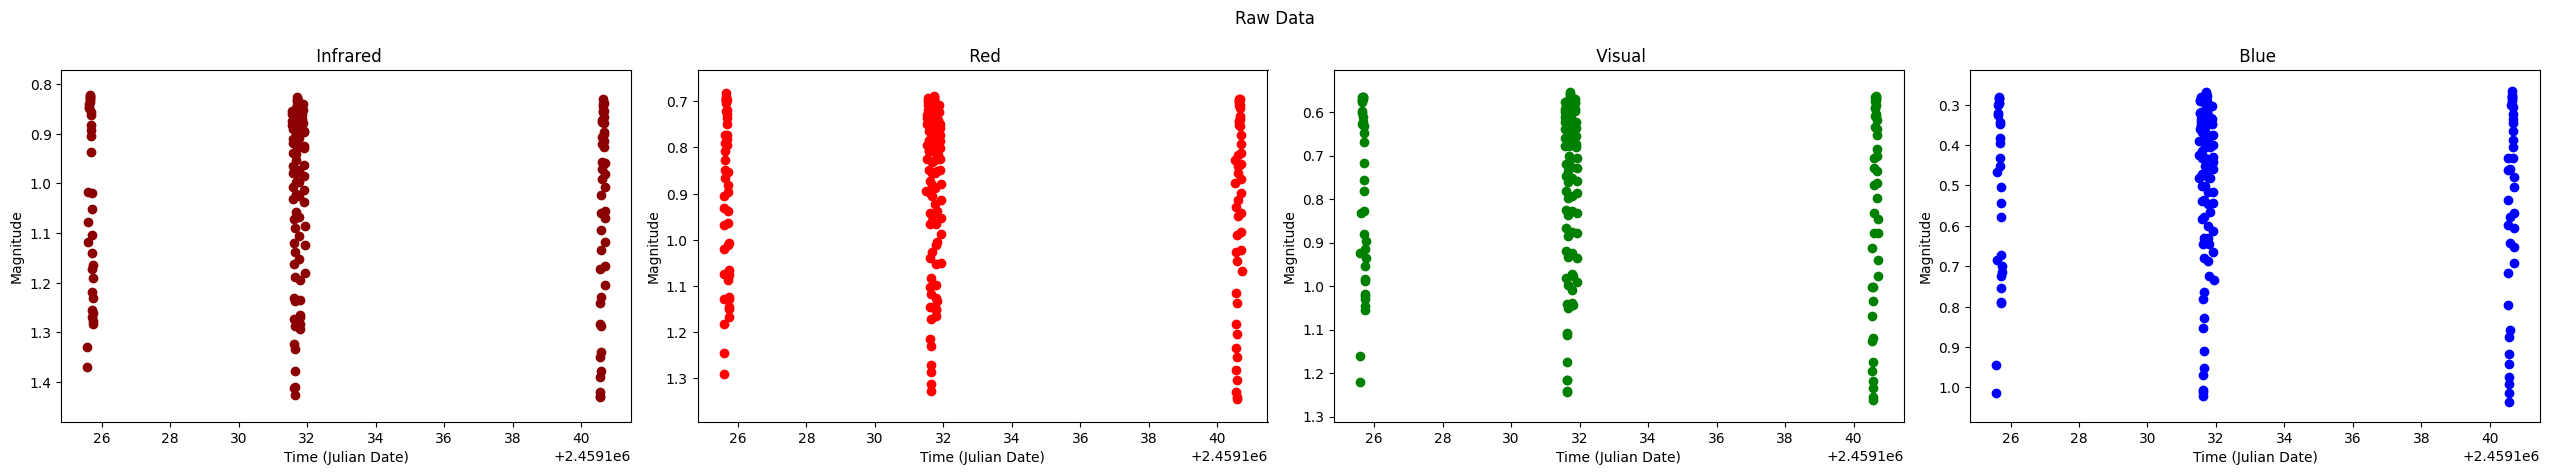

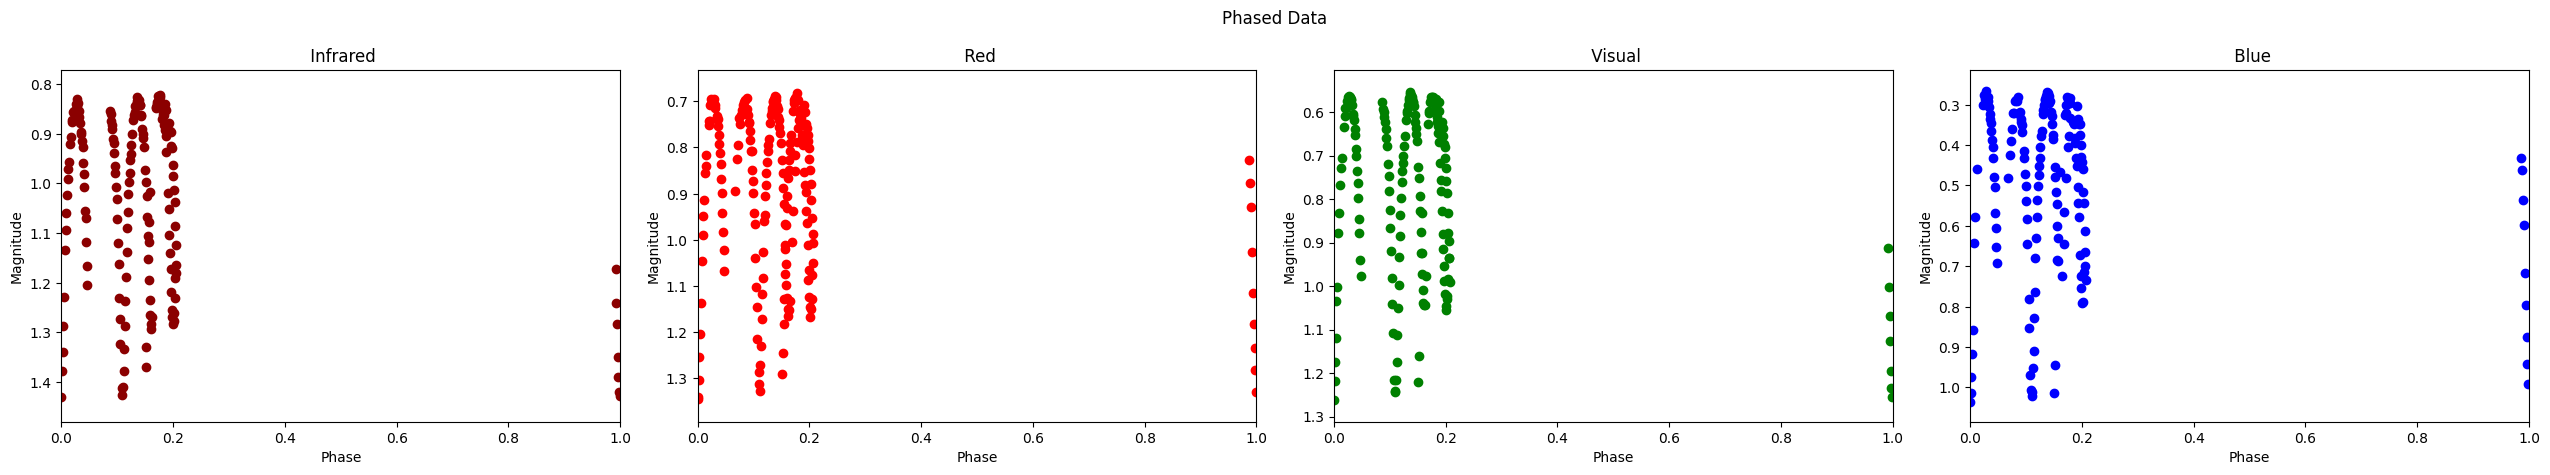

In [202]:
#inital lomb scargle calculation and graphing
graph_ls(mag, time)

What is the new best period? 0.3188


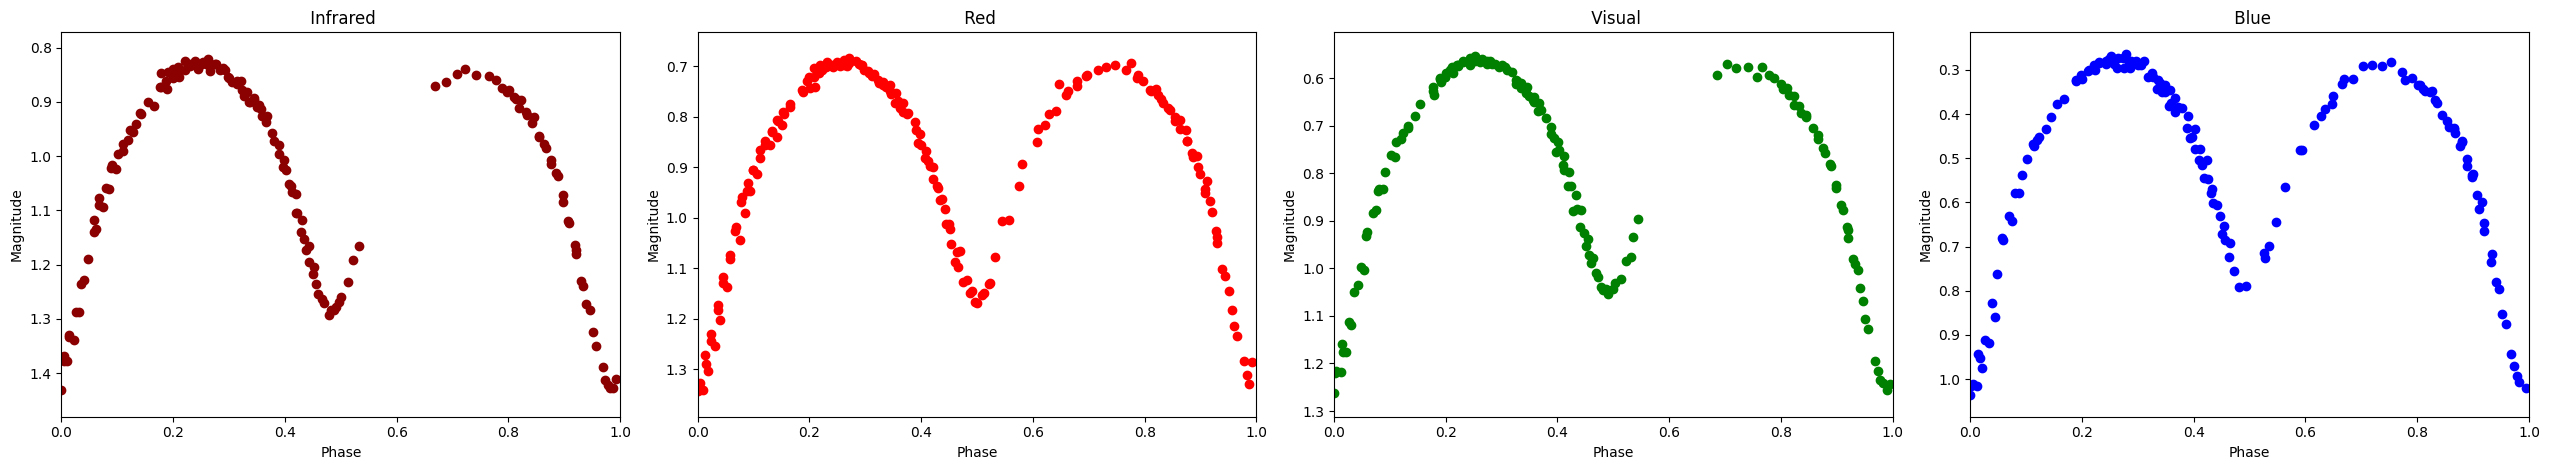

In [197]:
#if unhappy with resulting lomb scargle graph, run cell

period_choosing()

#input period
new_per = float(input('What is the new best period?'))

#regraphing with new period
revisgraph(mag, time, new_per)